In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoo_fin import stock_info as y_fin
import json
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

# Charting

In [2]:
def drawLine2P(x,y,xlims):
    xrange = np.arange(xlims[0],xlims[1],1)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return [xrange, k*xrange + b]

In [3]:
def PlotTimeSeries(ticker, years_ago=5, months_ago=0):
    #closeHist = pd.DataFrame(FinDB[ticker]['stockHist']['Close']).rename({'Close':'Price'}, axis=1)
    try:
        closeHist = pd.DataFrame(yf.Ticker(ticker).history(period='max')['Close']).rename({'Close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    except json.JSONDecodeError:
        closeHist = pd.DataFrame(y_fin.get_data(ticker)['close']).rename({'close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    closeHist = closeHist[closeHist.index > dt.datetime.now() + relativedelta(years=-years_ago)]
    closeHist.reset_index(inplace=True)
    closeHist['Month'] = closeHist.Date.apply(lambda x: dt.date(x.year, x.month, 1))
    closeHist = closeHist.groupby('Month').mean().rename({'Price':'Price(Monthly avg.)'}, axis=1)
    closeHist['x_index'] = pd.Series(range(len(closeHist.index)), closeHist.index)
    MinSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) > closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) > closeHist['Price(Monthly avg.)'])]
    MaxSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) < closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) < closeHist['Price(Monthly avg.)'])]
    BothSeries = pd.concat([MinSeries, MaxSeries]).sort_index()
    MaxMaxSeries = BothSeries[(BothSeries.shift(1) < BothSeries) & (BothSeries.shift(-1) < BothSeries)]
    MinMinSeries = BothSeries[(BothSeries.shift(1) > BothSeries) & (BothSeries.shift(-1) > BothSeries)]
    #3PTL Line
    #3PTL Line
    X = list()
    Y = list()
    x_1_date = MaxSeries.idxmax()
    x_1 = closeHist[closeHist.index==x_1_date].x_index.iloc[0]
    X.append(x_1)
    Y.append(MaxSeries.max())
    try:
        x_2_date = MaxSeries[MaxSeries.index > MaxSeries.idxmax()].idxmax()
        x_2 = closeHist[closeHist.index==x_2_date].x_index.iloc[0]
        X.append(x_2)
        Y.append(MaxSeries[MaxSeries.index > MaxSeries.idxmax()].max())
    except ValueError:
        pass
    plt.figure(figsize=[20,9])
    with plt.style.context('fivethirtyeight'):
        plt.plot(closeHist['Price(Monthly avg.)'], zorder=0)
        if len(X) < 2:
            pass
        else: 
            ThreePt = drawLine2P(x=X,y=Y,xlims=[closeHist['x_index'].values.min(),
                                      closeHist['x_index'].values.max()+1])
            plt.plot(closeHist.index, ThreePt[1],
                     c='g', linestyle='dashed')
        plt.scatter(MinSeries.index, 
                    MinSeries,
                    c='r', s=50, zorder=10)
        plt.scatter(MaxSeries.index, 
                    MaxSeries,
                    c='g', s=50, zorder=10)
        plt.scatter(MaxMaxSeries.index, 
                    MaxMaxSeries,
                    c='y', s=100, zorder=5)
        plt.scatter(MinMinSeries.index, 
                    MinMinSeries,
                    c='y', s=100, zorder=5)
    plt.legend([closeHist.columns[0]])
    plt.autoscale()
    plt.show()

In [4]:
def Chart3PTL(tickerListing, years=5, mos=0):
    List = tickerListing.split()
    for i in List:
        print(i)
        PlotTimeSeries(i, years, mos)

FMG.AX


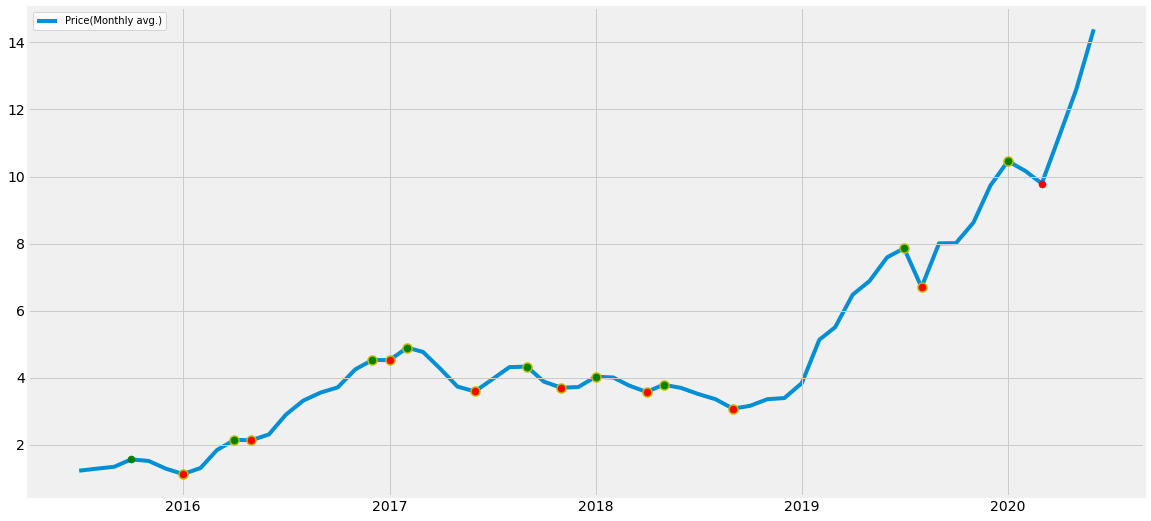

RMS.AX


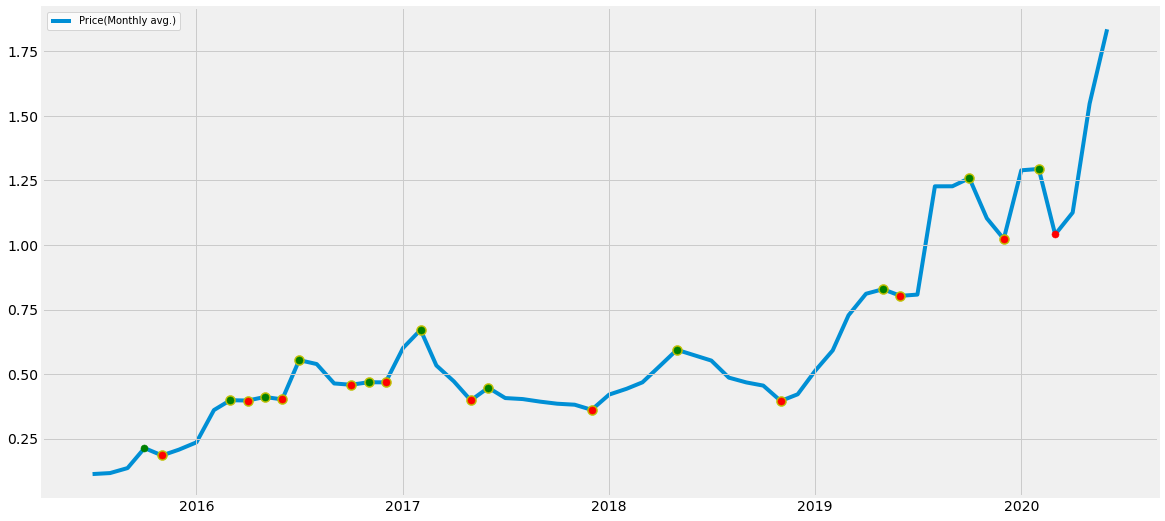

SFC.AX


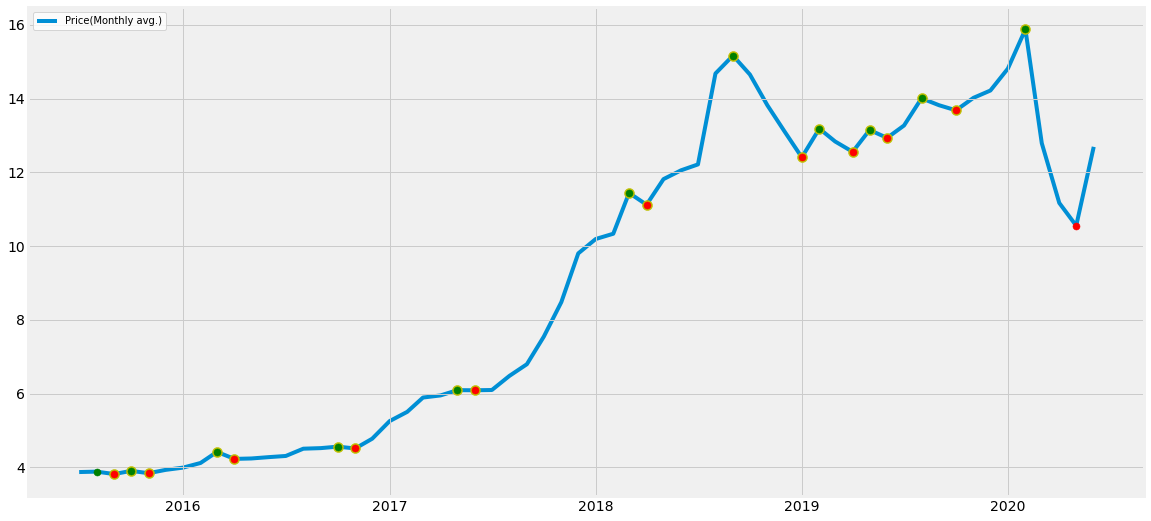

PRU.AX


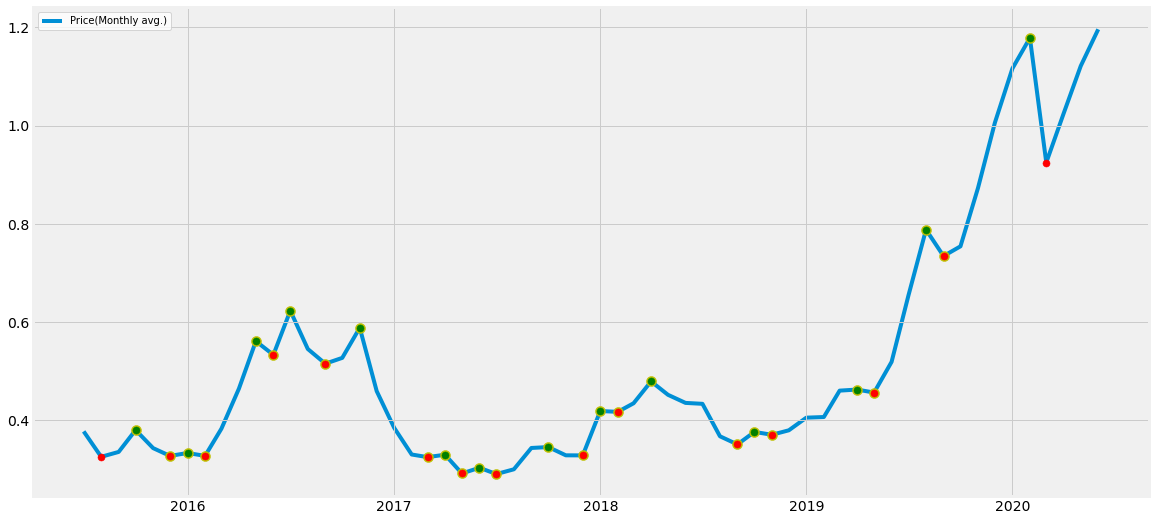

AQG.AX


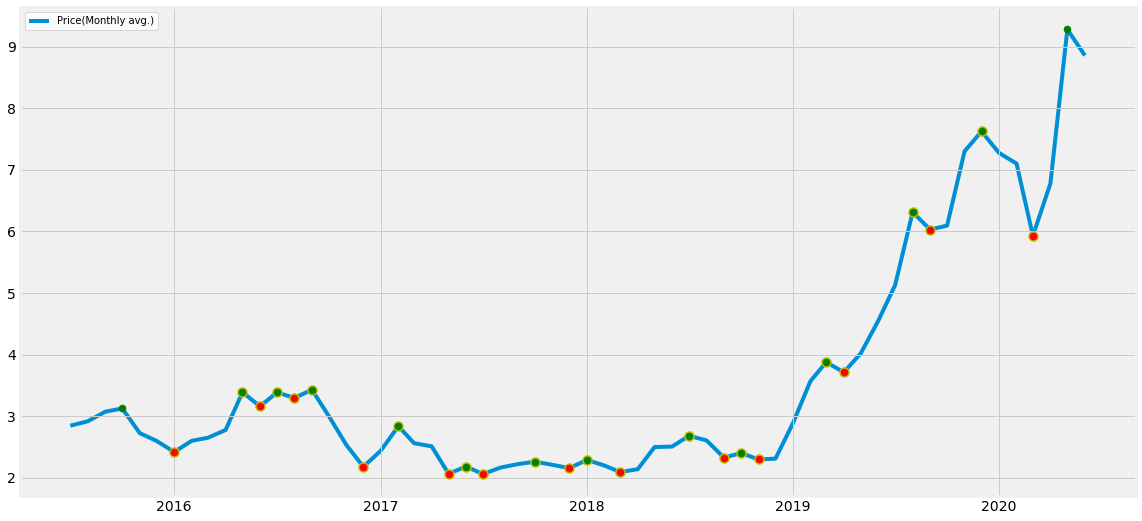

STO.AX


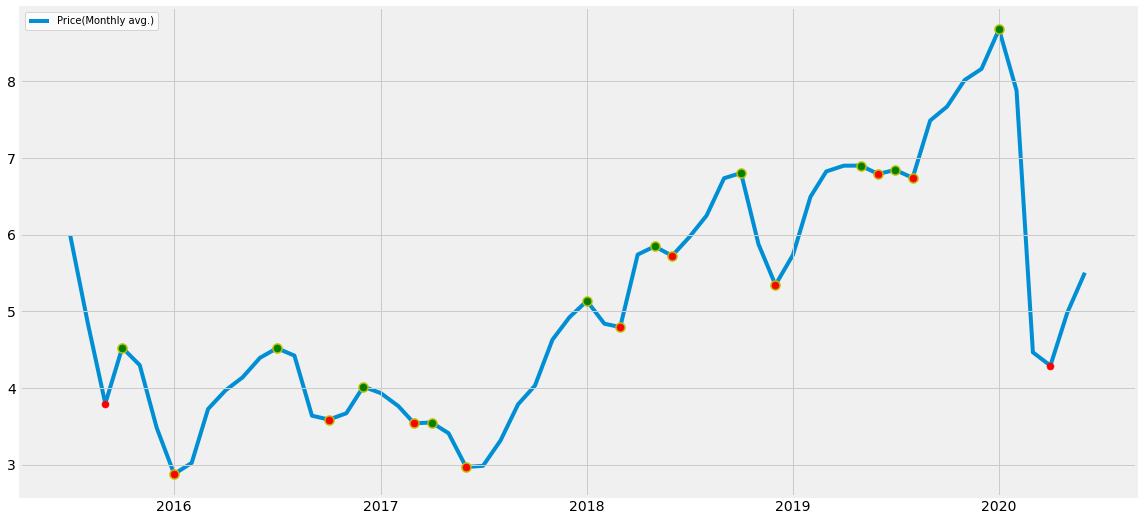

BFG.AX


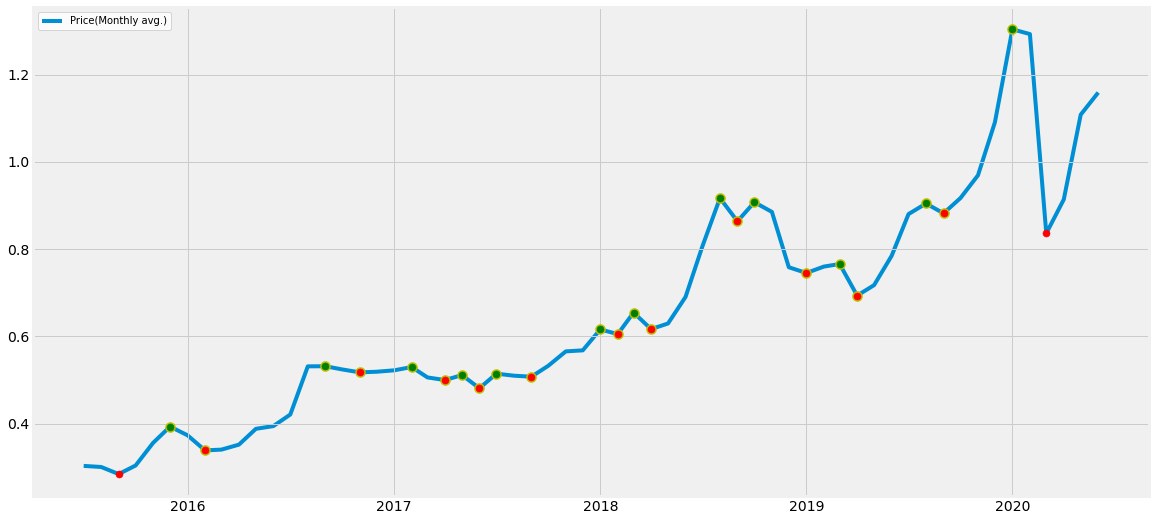

KOV.AX


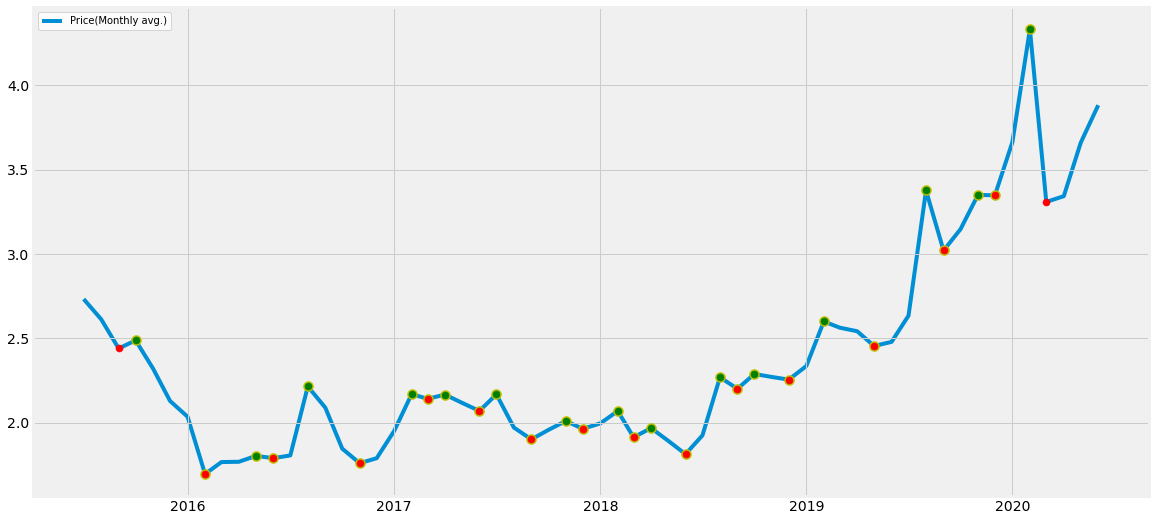

RRL.AX


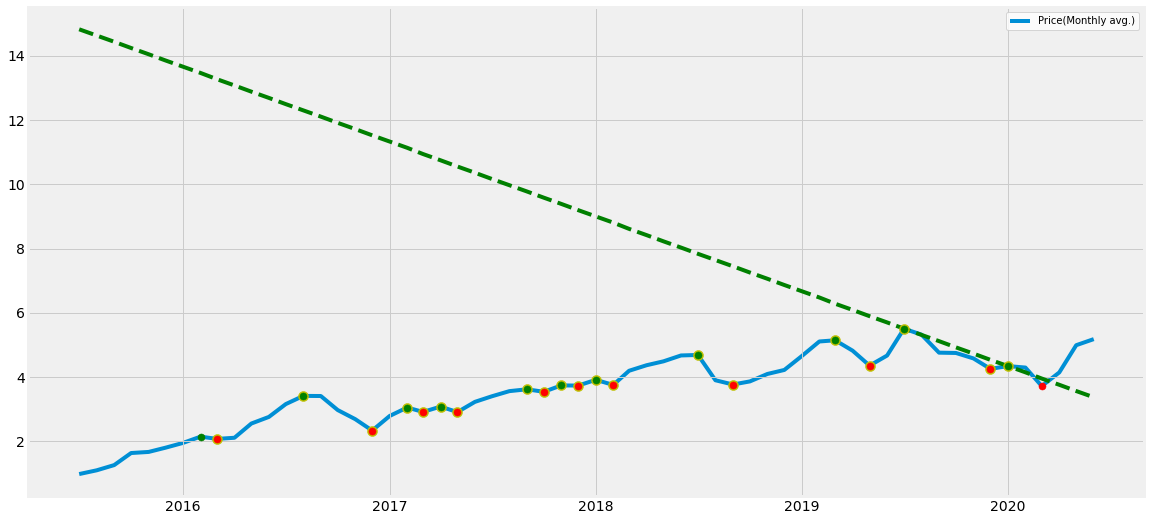

HAW.AX


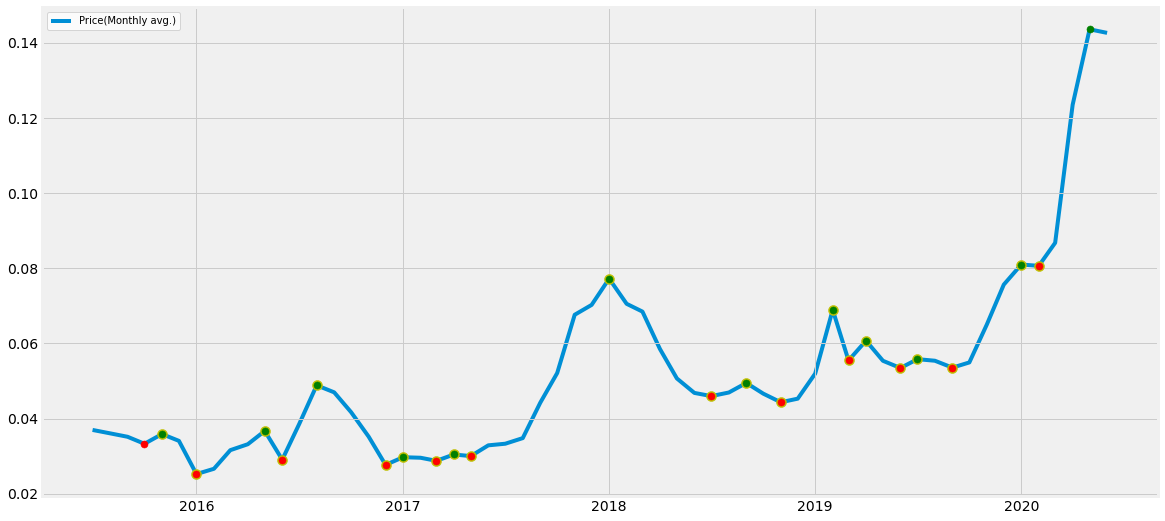

MRC.AX


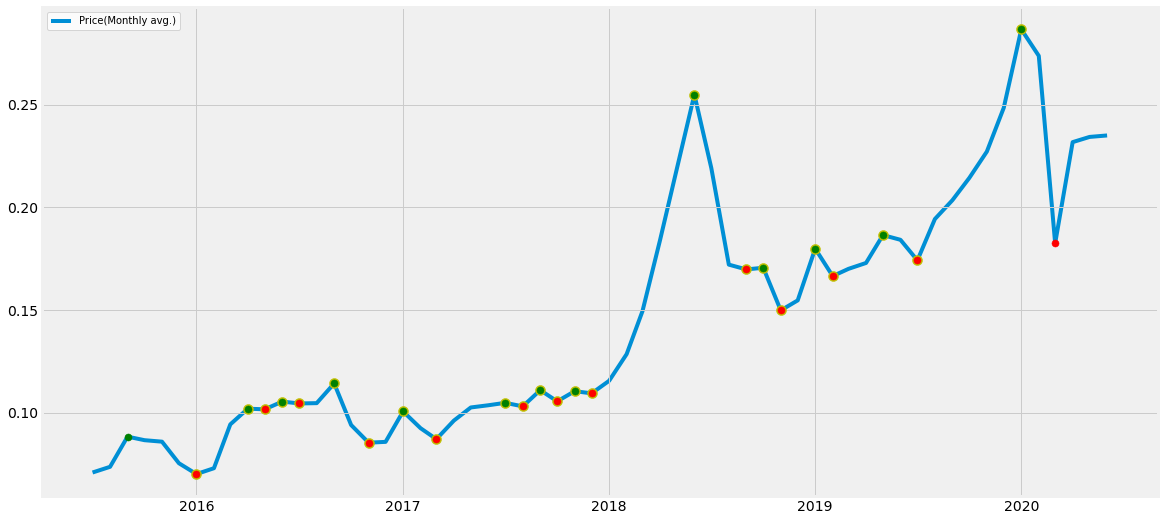

KRM.AX


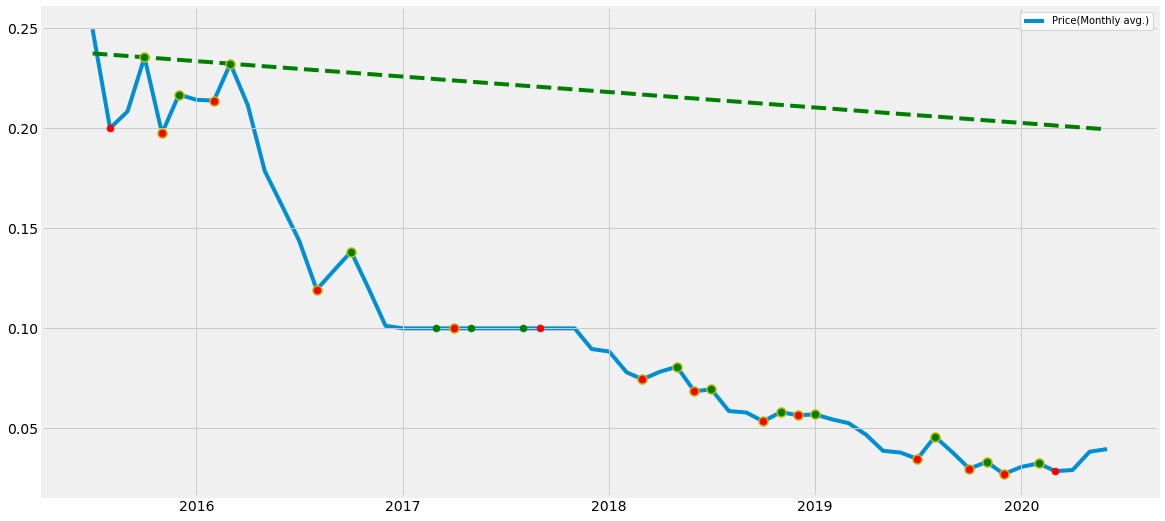

GEAR.AX


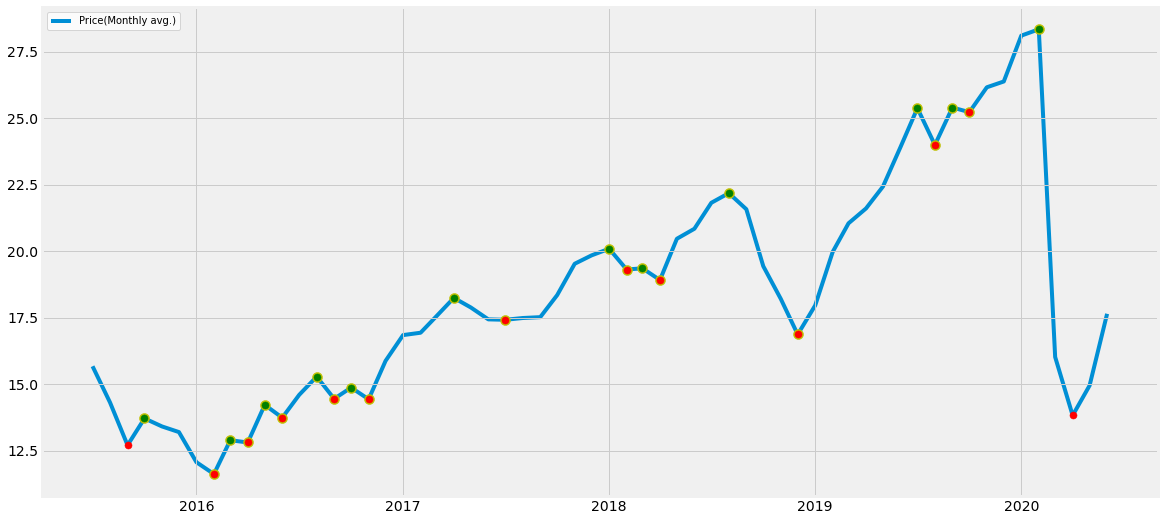

In [5]:
Chart3PTL("""FMG.AX
RMS.AX
SFC.AX
PRU.AX
AQG.AX
STO.AX
BFG.AX
KOV.AX
RRL.AX
HAW.AX
MRC.AX
KRM.AX
GEAR.AX""")